In [1]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# %matplotlib inline

import re
import sys
import os
from pprint import pprint
#coding:utf-8

#solved chinese display in matplotlib
from pylab import mpl
mpl.rcParams["font.family"] = 'DFKai-sb' 
mpl.rcParams['axes.unicode_minus'] = False

list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]
element="氫氦鋰鈹硼碳氮氧氟氖鈉鎂鋁矽磷硫氯氬鉀鈣鈧鈦釩鉻錳鐵鈷鎳銅鋅鎵鍺砷硒溴氪銣鍶銀鎘銦錫銻碲碘氙銫鋇鉑金汞鉈鉛鉍釙氡鍅鐳"

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


Using TensorFlow backend.


### Denoising Autoencoder with weak supervision

In [3]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [4]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [5]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#model path
path="Models/Model5_madeformulti"
if not os.path.isdir(path):
    os.mkdir(path)

#parameter setting    
BOW_dim=19404
DR_dim=100
loss_weights=[1,1,1,2]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
y=GaussianDropout(rate=0.2,name="noise")(x)
# y=Dense(units=2000,activation="sigmoid",name="Dense_1")(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense_1",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=x
y=Dense(units=BOW_dim,activation="sigmoid",use_bias=True,name="Dense_1")(y)
# y=Dense(units=BOW_dim,activation="sigmoid",name="Dense_2")(y)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder.initial.h5".format(path))
# encoder.save("encoder.initial.h5")
# decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="{}/Tri_DenoiseAutoEncoder.png".format(path))
plot_model(encoder,to_file="{}/encoder.png".format(path))
plot_model(decoder,to_file="{}/decoder.png".format(path))
# Open the file to record
with open('{}/Tri_AutoEencoderncoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/encoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/decoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 19404)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          1940400     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [13]:
Data=np.load("D:3.AutoencoderForArticle/BOW_binary_re_v02.npy")

In [14]:
with open("D:3.AutoencoderForArticle/train_dict_collect_industry_50000.p","rb") as f:
    train_dict_collect_industry_50000=pickle.load(f)

In [15]:
train_dict_collect_industry_50000.pop("控股","沒有")

array([  2249,  39220, 124022])

In [16]:
with open("D:3.AutoencoderForArticle/test_dict_collect_industry_50000.p","rb") as f:
    test_dict_collect_industry_50000=pickle.load(f)

In [17]:
test_dict_collect_industry_50000.pop("控股","沒有")

array([76531])

## Data generator

In [15]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size
        self.Data=Data

    def __len__(self):
         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
#         return 1
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = self.Data[batch_index[:,0]]
        batch_positive = self.Data[batch_index[:,1]]
        batch_negative = self.Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        

In [18]:
class HardTriGenerator(Sequence):

    def __init__(self, dict_id_news,Data, P=3,K=3):
        self.dict_id_news=dict_id_news
        self.industry=np.asarray(list(dict_id_news.keys()))
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        self.P=P
        self.K=K
        self.Data=Data

    def __len__(self):
        return int(np.floor(len(self.industry) / self.P))
#         return 1
    def __getitem__(self, idx):
        indusrty= self.industry[idx*self.P:(idx+1)*self.P]
        small_dict_id_news={i:np.random.choice(self.dict_id_news[i],size=self.K,replace=False) for i in indusrty}
        dict_small_triplet=dict()
        for k in small_dict_id_news:
            poslist=small_dict_id_news[k]
            poslen=len(poslist)
            neglist=[]
            for j in small_dict_id_news:
                if k!=j:neglist+=list(small_dict_id_news[j])
                neglen=len(neglist)
            indarray=np.zeros((int(poslen*(poslen-1)*neglen),3),dtype=int)
            i=0
            for ip1_,a in enumerate(poslist):
                for ip2_,p in enumerate(poslist):
                    if ip1_!=ip2_:
                        for in_,n in enumerate(neglist):
        #                   print(p1,p2,n)
                            indarray[i,0]=a
                            indarray[i,1]=p
                            indarray[i,2]=n
                            i+=1
        #                 break
        #             break
        #         break
            dict_small_triplet[k]=indarray            
        for i,k in enumerate(dict_small_triplet):
            if i==0:tripletindex=dict_small_triplet[k]
            else:tripletindex=np.concatenate((tripletindex,dict_small_triplet[k]),axis=0)   
        batch_anchor=self.Data[tripletindex[:,0]]
        batch_positive=self.Data[tripletindex[:,1]]
        batch_negative=self.Data[tripletindex[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))    
        
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.industry=np.random.permutation(self.industry)       

In [19]:
#setup

#instantiate generator
traingenerator=HardTriGenerator(dict_id_news=train_dict_collect_industry_50000,
                                Data=Data,
                                P=3, # remainder>=2;
                                K=5,
                               )
testgenerator=HardTriGenerator(dict_id_news=test_dict_collect_industry_50000,
                               Data=Data,P=3,K=5,
                              )

In [20]:
for _,i in enumerate(traingenerator):
    print(i[0][2].shape)
    break

(600, 19404)


## Callback function

In [21]:
from keras.callbacks import TerminateOnNaN,ModelCheckpoint,TensorBoard
#creat regular folder

regular_path =path+"/regular"
logname="Models/Model5_madeformulti"
if not os.path.isdir(regular_path):
    os.mkdir(regular_path)
# Instantiation claaback function
checkpointer = ModelCheckpoint(filepath='{}/bestmodel.hdf5'.format(path), verbose=0, save_best_only=True,period=10)
regularsave = ModelCheckpoint(filepath="{}".format(path)+'/regular/weights.{epoch:02d}.hdf5',
                              save_weights_only=True, 
                              verbose=0,
                              save_best_only=False,period=50)

tensorboard=TensorBoard(log_dir="./logs/{}".format(logname))

## Train

In [22]:
#initial
Tri_AutoEncoder=load_model("{}/Tri_AutoEncoder.initial.h5".format(path),custom_objects={"losspassfunction":losspassfunction})
#setup
epochs=3600
#train
History=Tri_AutoEncoder.fit_generator(callbacks=[checkpointer,tensorboard,regularsave],
                                      generator=traingenerator,
#                                       shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=1,use_multiprocessing=False,
                                      
                                    
                                     )
#save model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder_trained.h5".format(path))
Tri_AutoEncoder.save_weights("{}/weights.h5".format(path))

Epoch 1/3600
 - 15s - loss: 3.2682 - anchor_loss: 0.6197 - positive_loss: 0.6197 - negative_loss: 0.6197 - triplet_loss: 0.7046 - val_loss: 2.9959 - val_anchor_loss: 0.5256 - val_positive_loss: 0.5256 - val_negative_loss: 0.5256 - val_triplet_loss: 0.7096
Epoch 2/3600
 - 15s - loss: 2.8594 - anchor_loss: 0.4629 - positive_loss: 0.4629 - negative_loss: 0.4629 - triplet_loss: 0.7354 - val_loss: 2.6262 - val_anchor_loss: 0.3880 - val_positive_loss: 0.3880 - val_negative_loss: 0.3880 - val_triplet_loss: 0.7310
Epoch 3/3600
 - 15s - loss: 2.6338 - anchor_loss: 0.3414 - positive_loss: 0.3414 - negative_loss: 0.3415 - triplet_loss: 0.8048 - val_loss: 2.3588 - val_anchor_loss: 0.2892 - val_positive_loss: 0.2892 - val_negative_loss: 0.2892 - val_triplet_loss: 0.7456
Epoch 4/3600
 - 15s - loss: 2.3722 - anchor_loss: 0.2587 - positive_loss: 0.2587 - negative_loss: 0.2586 - triplet_loss: 0.7981 - val_loss: 2.2068 - val_anchor_loss: 0.2240 - val_positive_loss: 0.2240 - val_negative_loss: 0.2240 - v

Epoch 33/3600
 - 15s - loss: 1.5149 - anchor_loss: 0.0354 - positive_loss: 0.0354 - negative_loss: 0.0354 - triplet_loss: 0.7044 - val_loss: 1.4900 - val_anchor_loss: 0.0361 - val_positive_loss: 0.0361 - val_negative_loss: 0.0361 - val_triplet_loss: 0.6908
Epoch 34/3600
 - 14s - loss: 1.5874 - anchor_loss: 0.0344 - positive_loss: 0.0344 - negative_loss: 0.0345 - triplet_loss: 0.7420 - val_loss: 1.4739 - val_anchor_loss: 0.0360 - val_positive_loss: 0.0360 - val_negative_loss: 0.0360 - val_triplet_loss: 0.6830
Epoch 35/3600
 - 15s - loss: 1.6576 - anchor_loss: 0.0341 - positive_loss: 0.0341 - negative_loss: 0.0341 - triplet_loss: 0.7777 - val_loss: 1.4466 - val_anchor_loss: 0.0349 - val_positive_loss: 0.0349 - val_negative_loss: 0.0349 - val_triplet_loss: 0.6710
Epoch 36/3600
 - 15s - loss: 1.6272 - anchor_loss: 0.0342 - positive_loss: 0.0341 - negative_loss: 0.0342 - triplet_loss: 0.7623 - val_loss: 1.5728 - val_anchor_loss: 0.0363 - val_positive_loss: 0.0363 - val_negative_loss: 0.0363

Epoch 65/3600
 - 15s - loss: 1.1890 - anchor_loss: 0.0281 - positive_loss: 0.0281 - negative_loss: 0.0281 - triplet_loss: 0.5523 - val_loss: 1.0270 - val_anchor_loss: 0.0274 - val_positive_loss: 0.0274 - val_negative_loss: 0.0274 - val_triplet_loss: 0.4725
Epoch 66/3600
 - 15s - loss: 1.0018 - anchor_loss: 0.0277 - positive_loss: 0.0278 - negative_loss: 0.0277 - triplet_loss: 0.4593 - val_loss: 1.2316 - val_anchor_loss: 0.0277 - val_positive_loss: 0.0277 - val_negative_loss: 0.0277 - val_triplet_loss: 0.5742
Epoch 67/3600
 - 14s - loss: 1.1609 - anchor_loss: 0.0281 - positive_loss: 0.0281 - negative_loss: 0.0281 - triplet_loss: 0.5383 - val_loss: 1.1903 - val_anchor_loss: 0.0278 - val_positive_loss: 0.0278 - val_negative_loss: 0.0278 - val_triplet_loss: 0.5535
Epoch 68/3600
 - 15s - loss: 1.1556 - anchor_loss: 0.0292 - positive_loss: 0.0292 - negative_loss: 0.0292 - triplet_loss: 0.5340 - val_loss: 1.3870 - val_anchor_loss: 0.0278 - val_positive_loss: 0.0278 - val_negative_loss: 0.0278

Epoch 97/3600
 - 14s - loss: 1.0459 - anchor_loss: 0.0267 - positive_loss: 0.0267 - negative_loss: 0.0267 - triplet_loss: 0.4830 - val_loss: 1.1405 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0254 - val_negative_loss: 0.0254 - val_triplet_loss: 0.5322
Epoch 98/3600
 - 15s - loss: 0.9668 - anchor_loss: 0.0232 - positive_loss: 0.0232 - negative_loss: 0.0232 - triplet_loss: 0.4486 - val_loss: 1.0442 - val_anchor_loss: 0.0261 - val_positive_loss: 0.0261 - val_negative_loss: 0.0261 - val_triplet_loss: 0.4829
Epoch 99/3600
 - 14s - loss: 0.7314 - anchor_loss: 0.0250 - positive_loss: 0.0249 - negative_loss: 0.0250 - triplet_loss: 0.3283 - val_loss: 1.0610 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0253 - val_negative_loss: 0.0253 - val_triplet_loss: 0.4926
Epoch 100/3600
 - 15s - loss: 0.8593 - anchor_loss: 0.0249 - positive_loss: 0.0249 - negative_loss: 0.0249 - triplet_loss: 0.3922 - val_loss: 0.9818 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0256 - val_negative_loss: 0.025

Epoch 129/3600
 - 15s - loss: 0.8890 - anchor_loss: 0.0231 - positive_loss: 0.0231 - negative_loss: 0.0231 - triplet_loss: 0.4098 - val_loss: 0.6861 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0249 - val_negative_loss: 0.0249 - val_triplet_loss: 0.3056
Epoch 130/3600
 - 15s - loss: 0.7024 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 0.3167 - val_loss: 0.9486 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.0233 - val_triplet_loss: 0.4393
Epoch 131/3600
 - 15s - loss: 0.8127 - anchor_loss: 0.0232 - positive_loss: 0.0232 - negative_loss: 0.0232 - triplet_loss: 0.3716 - val_loss: 0.9298 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0242 - val_negative_loss: 0.0242 - val_triplet_loss: 0.4287
Epoch 132/3600
 - 14s - loss: 0.6577 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 0.2943 - val_loss: 0.9409 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0250 - val_negative_loss: 0.

Epoch 161/3600
 - 15s - loss: 0.8437 - anchor_loss: 0.0245 - positive_loss: 0.0245 - negative_loss: 0.0245 - triplet_loss: 0.3852 - val_loss: 1.0223 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0248 - val_negative_loss: 0.0248 - val_triplet_loss: 0.4739
Epoch 162/3600
 - 14s - loss: 0.7980 - anchor_loss: 0.0244 - positive_loss: 0.0244 - negative_loss: 0.0244 - triplet_loss: 0.3624 - val_loss: 0.6748 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.3028
Epoch 163/3600
 - 15s - loss: 0.5553 - anchor_loss: 0.0232 - positive_loss: 0.0232 - negative_loss: 0.0232 - triplet_loss: 0.2429 - val_loss: 0.7782 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0242 - val_negative_loss: 0.0242 - val_triplet_loss: 0.3528
Epoch 164/3600
 - 15s - loss: 0.5444 - anchor_loss: 0.0249 - positive_loss: 0.0249 - negative_loss: 0.0249 - triplet_loss: 0.2349 - val_loss: 0.9272 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0239 - val_negative_loss: 0.

Epoch 193/3600
 - 14s - loss: 0.4961 - anchor_loss: 0.0247 - positive_loss: 0.0247 - negative_loss: 0.0247 - triplet_loss: 0.2110 - val_loss: 0.8062 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0241 - val_negative_loss: 0.0241 - val_triplet_loss: 0.3669
Epoch 194/3600
 - 14s - loss: 0.5694 - anchor_loss: 0.0233 - positive_loss: 0.0233 - negative_loss: 0.0233 - triplet_loss: 0.2497 - val_loss: 0.6040 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0241 - val_negative_loss: 0.0241 - val_triplet_loss: 0.2658
Epoch 195/3600
 - 15s - loss: 0.6706 - anchor_loss: 0.0238 - positive_loss: 0.0238 - negative_loss: 0.0238 - triplet_loss: 0.2995 - val_loss: 0.7071 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0248 - val_negative_loss: 0.0248 - val_triplet_loss: 0.3164
Epoch 196/3600
 - 15s - loss: 0.6201 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.2767 - val_loss: 0.9294 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0241 - val_negative_loss: 0.

Epoch 225/3600
 - 14s - loss: 0.4282 - anchor_loss: 0.0229 - positive_loss: 0.0229 - negative_loss: 0.0229 - triplet_loss: 0.1798 - val_loss: 0.6930 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.3119
Epoch 226/3600
 - 15s - loss: 0.4940 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.2135 - val_loss: 0.8853 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.0233 - val_triplet_loss: 0.4077
Epoch 227/3600
 - 15s - loss: 0.4409 - anchor_loss: 0.0236 - positive_loss: 0.0236 - negative_loss: 0.0236 - triplet_loss: 0.1851 - val_loss: 0.7663 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.3493
Epoch 228/3600
 - 15s - loss: 0.4562 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.1946 - val_loss: 0.8440 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.

Epoch 257/3600
 - 15s - loss: 0.4538 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.1942 - val_loss: 0.6616 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0243 - val_negative_loss: 0.0243 - val_triplet_loss: 0.2943
Epoch 258/3600
 - 15s - loss: 0.3588 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.1463 - val_loss: 0.4757 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0236 - val_negative_loss: 0.0236 - val_triplet_loss: 0.2025
Epoch 259/3600
 - 15s - loss: 0.3742 - anchor_loss: 0.0231 - positive_loss: 0.0231 - negative_loss: 0.0231 - triplet_loss: 0.1525 - val_loss: 0.8468 - val_anchor_loss: 0.0245 - val_positive_loss: 0.0245 - val_negative_loss: 0.0245 - val_triplet_loss: 0.3867
Epoch 260/3600
 - 15s - loss: 0.4311 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.1826 - val_loss: 0.7691 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.

Epoch 289/3600
 - 15s - loss: 0.4333 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.1832 - val_loss: 0.4679 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2012
Epoch 290/3600
 - 15s - loss: 0.3950 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.1641 - val_loss: 0.5392 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.2353
Epoch 291/3600
 - 15s - loss: 0.2896 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.1115 - val_loss: 0.6749 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.3045
Epoch 292/3600
 - 14s - loss: 0.3578 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.1451 - val_loss: 0.4955 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.

Epoch 321/3600
 - 15s - loss: 0.4529 - anchor_loss: 0.0223 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.1929 - val_loss: 0.5580 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.2453
Epoch 322/3600
 - 15s - loss: 0.3807 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.1580 - val_loss: 0.6039 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.2682
Epoch 323/3600
 - 15s - loss: 0.2733 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.1036 - val_loss: 0.5254 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0240 - val_negative_loss: 0.0240 - val_triplet_loss: 0.2267
Epoch 324/3600
 - 15s - loss: 0.3417 - anchor_loss: 0.0237 - positive_loss: 0.0237 - negative_loss: 0.0237 - triplet_loss: 0.1353 - val_loss: 0.5868 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0236 - val_negative_loss: 0.

Epoch 353/3600
 - 15s - loss: 0.3061 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.1203 - val_loss: 0.6067 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2704
Epoch 354/3600
 - 15s - loss: 0.2915 - anchor_loss: 0.0219 - positive_loss: 0.0219 - negative_loss: 0.0219 - triplet_loss: 0.1129 - val_loss: 0.4887 - val_anchor_loss: 0.0246 - val_positive_loss: 0.0246 - val_negative_loss: 0.0246 - val_triplet_loss: 0.2075
Epoch 355/3600
 - 15s - loss: 0.2985 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.1156 - val_loss: 0.7534 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.0230 - val_triplet_loss: 0.3422
Epoch 356/3600
 - 15s - loss: 0.3705 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 0.1507 - val_loss: 0.7268 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0240 - val_negative_loss: 0.

Epoch 385/3600
 - 14s - loss: 0.1991 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0674 - val_loss: 0.5829 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2593
Epoch 386/3600
 - 15s - loss: 0.2969 - anchor_loss: 0.0242 - positive_loss: 0.0242 - negative_loss: 0.0242 - triplet_loss: 0.1121 - val_loss: 0.5193 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.2263
Epoch 387/3600
 - 14s - loss: 0.2405 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0884 - val_loss: 0.5087 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2225
Epoch 388/3600
 - 15s - loss: 0.2531 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0943 - val_loss: 0.6212 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.

Epoch 417/3600
 - 15s - loss: 0.2922 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.1143 - val_loss: 0.6944 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.3128
Epoch 418/3600
 - 15s - loss: 0.1916 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0640 - val_loss: 0.5387 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.2348
Epoch 419/3600
 - 14s - loss: 0.1859 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0605 - val_loss: 0.7369 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.3344
Epoch 420/3600
 - 15s - loss: 0.2552 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0944 - val_loss: 0.6089 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.

Epoch 449/3600
 - 14s - loss: 0.1679 - anchor_loss: 0.0227 - positive_loss: 0.0228 - negative_loss: 0.0228 - triplet_loss: 0.0498 - val_loss: 0.5498 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2423
Epoch 450/3600
 - 15s - loss: 0.2198 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0783 - val_loss: 0.4323 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0243 - val_negative_loss: 0.0243 - val_triplet_loss: 0.1797
Epoch 451/3600
 - 15s - loss: 0.3113 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.1223 - val_loss: 0.6428 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2895
Epoch 452/3600
 - 15s - loss: 0.4171 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.1755 - val_loss: 0.4642 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.

Epoch 481/3600
 - 15s - loss: 0.2424 - anchor_loss: 0.0219 - positive_loss: 0.0219 - negative_loss: 0.0219 - triplet_loss: 0.0883 - val_loss: 0.5039 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2189
Epoch 482/3600
 - 15s - loss: 0.2498 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.0935 - val_loss: 0.5440 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2395
Epoch 483/3600
 - 15s - loss: 0.1489 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.0415 - val_loss: 0.4301 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.1811
Epoch 484/3600
 - 15s - loss: 0.2224 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0788 - val_loss: 0.4439 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.

Epoch 513/3600
 - 15s - loss: 0.2756 - anchor_loss: 0.0217 - positive_loss: 0.0217 - negative_loss: 0.0217 - triplet_loss: 0.1052 - val_loss: 0.3820 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1594
Epoch 514/3600
 - 15s - loss: 0.2497 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0943 - val_loss: 0.3772 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1564
Epoch 515/3600
 - 15s - loss: 0.2694 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.1033 - val_loss: 0.4765 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2060
Epoch 516/3600
 - 15s - loss: 0.2177 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0772 - val_loss: 0.4444 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.

Epoch 545/3600
 - 15s - loss: 0.2038 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0706 - val_loss: 0.6210 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2778
Epoch 546/3600
 - 15s - loss: 0.1518 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0428 - val_loss: 0.5549 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2451
Epoch 547/3600
 - 15s - loss: 0.2651 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.1018 - val_loss: 0.5896 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2618
Epoch 548/3600
 - 15s - loss: 0.1568 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0470 - val_loss: 0.4052 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.

Epoch 577/3600
 - 15s - loss: 0.1459 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0426 - val_loss: 0.6109 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2733
Epoch 578/3600
 - 15s - loss: 0.1187 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0285 - val_loss: 0.5017 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.2176
Epoch 579/3600
 - 15s - loss: 0.1527 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0439 - val_loss: 0.3455 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.1408
Epoch 580/3600
 - 15s - loss: 0.1310 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0336 - val_loss: 0.5508 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.

Epoch 609/3600
 - 14s - loss: 0.1079 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0222 - val_loss: 0.5968 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.2665
Epoch 610/3600
 - 15s - loss: 0.2061 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0216 - triplet_loss: 0.0707 - val_loss: 0.5413 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.2378
Epoch 611/3600
 - 15s - loss: 0.2387 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.0858 - val_loss: 0.4261 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.1794
Epoch 612/3600
 - 15s - loss: 0.2525 - anchor_loss: 0.0214 - positive_loss: 0.0213 - negative_loss: 0.0214 - triplet_loss: 0.0942 - val_loss: 0.4157 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.

Epoch 641/3600
 - 15s - loss: 0.1372 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0368 - val_loss: 0.5964 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2661
Epoch 642/3600
 - 14s - loss: 0.1309 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.0324 - val_loss: 0.4138 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1745
Epoch 643/3600
 - 14s - loss: 0.1823 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0593 - val_loss: 0.3856 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1595
Epoch 644/3600
 - 15s - loss: 0.1179 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0288 - val_loss: 0.4576 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.

Epoch 673/3600
 - 15s - loss: 0.1224 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.0285 - val_loss: 0.5566 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2473
Epoch 674/3600
 - 14s - loss: 0.1119 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0242 - val_loss: 0.5452 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.0233 - val_triplet_loss: 0.2377
Epoch 675/3600
 - 15s - loss: 0.1991 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.0663 - val_loss: 0.4757 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.2050
Epoch 676/3600
 - 15s - loss: 0.1643 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.0495 - val_loss: 0.3891 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.

Epoch 705/3600
 - 15s - loss: 0.0932 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0152 - val_loss: 0.4631 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1983
Epoch 706/3600
 - 15s - loss: 0.1516 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0449 - val_loss: 0.5557 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.2443
Epoch 707/3600
 - 14s - loss: 0.1401 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0391 - val_loss: 0.5435 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2392
Epoch 708/3600
 - 15s - loss: 0.2026 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0710 - val_loss: 0.4341 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.

Epoch 737/3600
 - 15s - loss: 0.1542 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0469 - val_loss: 0.4177 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1755
Epoch 738/3600
 - 14s - loss: 0.1569 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0466 - val_loss: 0.4680 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.0230 - val_triplet_loss: 0.1994
Epoch 739/3600
 - 15s - loss: 0.1044 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0216 - val_loss: 0.4082 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.1709
Epoch 740/3600
 - 14s - loss: 0.1314 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0337 - val_loss: 0.4850 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.

Epoch 769/3600
 - 15s - loss: 0.1517 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0438 - val_loss: 0.2893 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1125
Epoch 770/3600
 - 15s - loss: 0.1376 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0379 - val_loss: 0.4697 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2032
Epoch 771/3600
 - 15s - loss: 0.1145 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.0258 - val_loss: 0.4032 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1691
Epoch 772/3600
 - 15s - loss: 0.1020 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0194 - val_loss: 0.4478 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.

Epoch 801/3600
 - 15s - loss: 0.1318 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0345 - val_loss: 0.4793 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2073
Epoch 802/3600
 - 14s - loss: 0.2046 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0723 - val_loss: 0.4087 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.1703
Epoch 803/3600
 - 15s - loss: 0.1010 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0207 - val_loss: 0.5100 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.0230 - val_triplet_loss: 0.2205
Epoch 804/3600
 - 15s - loss: 0.1881 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0629 - val_loss: 0.4535 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.

Epoch 833/3600
 - 14s - loss: 0.1373 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0382 - val_loss: 0.6513 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2934
Epoch 834/3600
 - 15s - loss: 0.1229 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0292 - val_loss: 0.4978 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.0228 - val_triplet_loss: 0.2146
Epoch 835/3600
 - 14s - loss: 0.1252 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0320 - val_loss: 0.4431 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1910
Epoch 836/3600
 - 15s - loss: 0.1525 - anchor_loss: 0.0198 - positive_loss: 0.0197 - negative_loss: 0.0198 - triplet_loss: 0.0466 - val_loss: 0.5783 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.

Epoch 865/3600
 - 15s - loss: 0.0917 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0161 - val_loss: 0.6188 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.2750
Epoch 866/3600
 - 15s - loss: 0.1478 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0205 - triplet_loss: 0.0432 - val_loss: 0.6314 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2831
Epoch 867/3600
 - 15s - loss: 0.1163 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0280 - val_loss: 0.5301 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2326
Epoch 868/3600
 - 15s - loss: 0.1399 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0380 - val_loss: 0.3836 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.

Epoch 897/3600
 - 15s - loss: 0.1130 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0256 - val_loss: 0.4493 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1919
Epoch 898/3600
 - 15s - loss: 0.1245 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0309 - val_loss: 0.5587 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2463
Epoch 899/3600
 - 15s - loss: 0.0997 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0195 - val_loss: 0.3888 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1641
Epoch 900/3600
 - 15s - loss: 0.1371 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0377 - val_loss: 0.3792 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.

Epoch 929/3600
 - 15s - loss: 0.0980 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0188 - val_loss: 0.4753 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2060
Epoch 930/3600
 - 15s - loss: 0.0885 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0132 - val_loss: 0.5848 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.2592
Epoch 931/3600
 - 15s - loss: 0.0957 - anchor_loss: 0.0217 - positive_loss: 0.0217 - negative_loss: 0.0217 - triplet_loss: 0.0153 - val_loss: 0.4380 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1869
Epoch 932/3600
 - 14s - loss: 0.1390 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0389 - val_loss: 0.5930 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.

Epoch 961/3600
 - 14s - loss: 0.1497 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0442 - val_loss: 0.5375 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.2349
Epoch 962/3600
 - 15s - loss: 0.1021 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0199 - val_loss: 0.3976 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1661
Epoch 963/3600
 - 15s - loss: 0.1558 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0457 - val_loss: 0.4741 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.0228 - val_triplet_loss: 0.2029
Epoch 964/3600
 - 15s - loss: 0.0958 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0168 - val_loss: 0.4423 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.

Epoch 993/3600
 - 14s - loss: 0.1051 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0222 - val_loss: 0.3954 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1674
Epoch 994/3600
 - 15s - loss: 0.0843 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0125 - val_loss: 0.4747 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.2034
Epoch 995/3600
 - 15s - loss: 0.0861 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0127 - val_loss: 0.4336 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1850
Epoch 996/3600
 - 14s - loss: 0.0846 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0124 - val_loss: 0.3238 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.

Epoch 1025/3600
 - 15s - loss: 0.1133 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0274 - val_loss: 0.4113 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1736
Epoch 1026/3600
 - 15s - loss: 0.0775 - anchor_loss: 0.0197 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0093 - val_loss: 0.4871 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2118
Epoch 1027/3600
 - 15s - loss: 0.1390 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0394 - val_loss: 0.3972 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1663
Epoch 1028/3600
 - 15s - loss: 0.1322 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0347 - val_loss: 0.5262 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss

Epoch 1057/3600
 - 15s - loss: 0.1203 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0301 - val_loss: 0.3060 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1221
Epoch 1058/3600
 - 15s - loss: 0.1020 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0215 - val_loss: 0.4121 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1745
Epoch 1059/3600
 - 14s - loss: 0.1101 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0244 - val_loss: 0.5083 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2241
Epoch 1060/3600
 - 14s - loss: 0.1006 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0203 - val_loss: 0.4730 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1089/3600
 - 15s - loss: 0.1074 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0226 - val_loss: 0.2949 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1161
Epoch 1090/3600
 - 14s - loss: 0.1868 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0639 - val_loss: 0.4665 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.2001
Epoch 1091/3600
 - 15s - loss: 0.1003 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0208 - val_loss: 0.4447 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1906
Epoch 1092/3600
 - 15s - loss: 0.1592 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0484 - val_loss: 0.2639 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1121/3600
 - 15s - loss: 0.0824 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0103 - val_loss: 0.5447 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2402
Epoch 1122/3600
 - 15s - loss: 0.0768 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0083 - val_loss: 0.6596 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2978
Epoch 1123/3600
 - 15s - loss: 0.0813 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0125 - val_loss: 0.4161 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1763
Epoch 1124/3600
 - 14s - loss: 0.0899 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0140 - val_loss: 0.3536 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss

Epoch 1153/3600
 - 15s - loss: 0.0798 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0079 - val_loss: 0.5071 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2226
Epoch 1154/3600
 - 15s - loss: 0.0928 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0173 - val_loss: 0.4572 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.1957
Epoch 1155/3600
 - 14s - loss: 0.0754 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0074 - val_loss: 0.5451 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2399
Epoch 1156/3600
 - 15s - loss: 0.0798 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0117 - val_loss: 0.7837 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss

Epoch 1185/3600
 - 14s - loss: 0.0994 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0194 - val_loss: 0.4684 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2036
Epoch 1186/3600
 - 15s - loss: 0.1016 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0203 - val_loss: 0.5084 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2232
Epoch 1187/3600
 - 14s - loss: 0.1434 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0414 - val_loss: 0.4679 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2018
Epoch 1188/3600
 - 15s - loss: 0.0806 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0112 - val_loss: 0.5349 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 1217/3600
 - 15s - loss: 0.0949 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0164 - val_loss: 0.4475 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1916
Epoch 1218/3600
 - 14s - loss: 0.1037 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0217 - val_loss: 0.3810 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1590
Epoch 1219/3600
 - 15s - loss: 0.0919 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0179 - val_loss: 0.4571 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1967
Epoch 1220/3600
 - 15s - loss: 0.0732 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0078 - val_loss: 0.6574 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss

Epoch 1249/3600
 - 15s - loss: 0.1426 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0433 - val_loss: 0.4265 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1822
Epoch 1250/3600
 - 15s - loss: 0.0870 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0191 - triplet_loss: 0.0148 - val_loss: 0.4812 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2087
Epoch 1251/3600
 - 14s - loss: 0.0634 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0018 - val_loss: 0.3726 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1548
Epoch 1252/3600
 - 15s - loss: 0.0733 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0074 - val_loss: 0.3714 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 1281/3600
 - 15s - loss: 0.1250 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0340 - val_loss: 0.4061 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1727
Epoch 1282/3600
 - 15s - loss: 0.0904 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0164 - val_loss: 0.3755 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1553
Epoch 1283/3600
 - 15s - loss: 0.0843 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0123 - val_loss: 0.3988 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1672
Epoch 1284/3600
 - 15s - loss: 0.0709 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0063 - val_loss: 0.4160 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss

Epoch 1313/3600
 - 14s - loss: 0.0854 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0148 - val_loss: 0.3663 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1510
Epoch 1314/3600
 - 15s - loss: 0.1439 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0425 - val_loss: 0.4624 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1979
Epoch 1315/3600
 - 14s - loss: 0.1009 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0202 - val_loss: 0.6378 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2869
Epoch 1316/3600
 - 15s - loss: 0.0787 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0098 - val_loss: 0.3917 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss

Epoch 1345/3600
 - 15s - loss: 0.1056 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0240 - val_loss: 0.3132 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1254
Epoch 1346/3600
 - 15s - loss: 0.0885 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0143 - val_loss: 0.2244 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0805
Epoch 1347/3600
 - 15s - loss: 0.1208 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0207 - triplet_loss: 0.0294 - val_loss: 0.3204 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1296
Epoch 1348/3600
 - 15s - loss: 0.0790 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0123 - val_loss: 0.4860 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss

Epoch 1377/3600
 - 15s - loss: 0.0825 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0141 - val_loss: 0.2621 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1005
Epoch 1378/3600
 - 15s - loss: 0.1221 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0198 - triplet_loss: 0.0314 - val_loss: 0.2694 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1013
Epoch 1379/3600
 - 15s - loss: 0.0760 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0077 - val_loss: 0.5277 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2326
Epoch 1380/3600
 - 15s - loss: 0.0968 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0190 - val_loss: 0.4297 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1409/3600
 - 15s - loss: 0.0774 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0105 - val_loss: 0.4637 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2012
Epoch 1410/3600
 - 15s - loss: 0.0855 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0114 - val_loss: 0.3632 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1507
Epoch 1411/3600
 - 15s - loss: 0.0867 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0146 - val_loss: 0.6549 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2966
Epoch 1412/3600
 - 15s - loss: 0.0740 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0062 - val_loss: 0.2591 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 1441/3600
 - 15s - loss: 0.0756 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0094 - val_loss: 0.5189 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.2261
Epoch 1442/3600
 - 15s - loss: 0.0839 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0129 - val_loss: 0.3755 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1559
Epoch 1443/3600
 - 15s - loss: 0.1057 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0244 - val_loss: 0.5153 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2264
Epoch 1444/3600
 - 15s - loss: 0.0761 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0099 - val_loss: 0.4144 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 1473/3600
 - 15s - loss: 0.0770 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0095 - val_loss: 0.2552 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0963
Epoch 1474/3600
 - 14s - loss: 0.0828 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0125 - val_loss: 0.4384 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1884
Epoch 1475/3600
 - 15s - loss: 0.0794 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0115 - val_loss: 0.6444 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2899
Epoch 1476/3600
 - 15s - loss: 0.0791 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0113 - val_loss: 0.3537 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1505/3600
 - 14s - loss: 0.0734 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0095 - val_loss: 0.5103 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2238
Epoch 1506/3600
 - 15s - loss: 0.0854 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0124 - val_loss: 0.4531 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1978
Epoch 1507/3600
 - 14s - loss: 0.0838 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0143 - val_loss: 0.3615 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1493
Epoch 1508/3600
 - 15s - loss: 0.1083 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0258 - val_loss: 0.3852 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss

Epoch 1537/3600
 - 15s - loss: 0.0715 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0088 - val_loss: 0.4627 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2005
Epoch 1538/3600
 - 15s - loss: 0.0688 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0050 - val_loss: 0.5912 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2651
Epoch 1539/3600
 - 15s - loss: 0.0596 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0031 - val_loss: 0.3714 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1547
Epoch 1540/3600
 - 14s - loss: 0.0645 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0044 - val_loss: 0.5647 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss

Epoch 1569/3600
 - 14s - loss: 0.1098 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0279 - val_loss: 0.4879 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2124
Epoch 1570/3600
 - 14s - loss: 0.0707 - anchor_loss: 0.0189 - positive_loss: 0.0188 - negative_loss: 0.0189 - triplet_loss: 0.0071 - val_loss: 0.4289 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1838
Epoch 1571/3600
 - 15s - loss: 0.0731 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0196 - triplet_loss: 0.0072 - val_loss: 0.3455 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1406
Epoch 1572/3600
 - 15s - loss: 0.0666 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0047 - val_loss: 0.4227 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 1601/3600
 - 15s - loss: 0.0657 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0047 - val_loss: 0.4429 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1914
Epoch 1602/3600
 - 15s - loss: 0.0638 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0037 - val_loss: 0.3740 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1560
Epoch 1603/3600
 - 15s - loss: 0.0604 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0024 - val_loss: 0.3252 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1315
Epoch 1604/3600
 - 15s - loss: 0.0837 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0128 - val_loss: 0.3579 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 1633/3600
 - 15s - loss: 0.0630 - anchor_loss: 0.0191 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0028 - val_loss: 0.3384 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1376
Epoch 1634/3600
 - 15s - loss: 0.1121 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0277 - val_loss: 0.2785 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1088
Epoch 1635/3600
 - 14s - loss: 0.0860 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0134 - val_loss: 0.5058 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.2197
Epoch 1636/3600
 - 15s - loss: 0.0720 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0068 - val_loss: 0.4470 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 1665/3600
 - 15s - loss: 0.1120 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0273 - val_loss: 0.2870 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1125
Epoch 1666/3600
 - 15s - loss: 0.0675 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0050 - val_loss: 0.5776 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2580
Epoch 1667/3600
 - 15s - loss: 0.0974 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0205 - val_loss: 0.3841 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1599
Epoch 1668/3600
 - 15s - loss: 0.0658 - anchor_loss: 0.0190 - positive_loss: 0.0189 - negative_loss: 0.0190 - triplet_loss: 0.0045 - val_loss: 0.3488 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss

Epoch 1697/3600
 - 14s - loss: 0.0752 - anchor_loss: 0.0201 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0075 - val_loss: 0.2718 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1035
Epoch 1698/3600
 - 15s - loss: 0.0669 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0046 - val_loss: 0.4734 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2067
Epoch 1699/3600
 - 14s - loss: 0.0678 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0064 - val_loss: 0.5067 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2226
Epoch 1700/3600
 - 15s - loss: 0.0954 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0203 - val_loss: 0.3922 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss

Epoch 1729/3600
 - 15s - loss: 0.0789 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0119 - val_loss: 0.4403 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1880
Epoch 1730/3600
 - 14s - loss: 0.0630 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0030 - val_loss: 0.3254 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1325
Epoch 1731/3600
 - 15s - loss: 0.0602 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0018 - val_loss: 0.4041 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1713
Epoch 1732/3600
 - 15s - loss: 0.0708 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0060 - val_loss: 0.4807 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss

Epoch 1761/3600
 - 14s - loss: 0.0767 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0099 - val_loss: 0.3780 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1592
Epoch 1762/3600
 - 15s - loss: 0.1052 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0235 - val_loss: 0.2881 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1128
Epoch 1763/3600
 - 15s - loss: 0.0811 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0136 - val_loss: 0.4273 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1820
Epoch 1764/3600
 - 15s - loss: 0.1050 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0243 - val_loss: 0.4607 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 1793/3600
 - 15s - loss: 0.0608 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0021 - val_loss: 0.2993 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1200
Epoch 1794/3600
 - 15s - loss: 0.0840 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0138 - val_loss: 0.3506 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1448
Epoch 1795/3600
 - 15s - loss: 0.0822 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0118 - val_loss: 0.3759 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1565
Epoch 1796/3600
 - 15s - loss: 0.0740 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0077 - val_loss: 0.5273 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1825/3600
 - 15s - loss: 0.0665 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0053 - val_loss: 0.2743 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1062
Epoch 1826/3600
 - 14s - loss: 0.0681 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0048 - val_loss: 0.5611 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2510
Epoch 1827/3600
 - 14s - loss: 0.0648 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0055 - val_loss: 0.3197 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1298
Epoch 1828/3600
 - 15s - loss: 0.1114 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0272 - val_loss: 0.5076 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss

Epoch 1857/3600
 - 14s - loss: 0.0634 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0032 - val_loss: 0.4746 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2071
Epoch 1858/3600
 - 15s - loss: 0.0698 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0088 - val_loss: 0.5749 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2575
Epoch 1859/3600
 - 14s - loss: 0.0650 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0052 - val_loss: 0.4070 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1727
Epoch 1860/3600
 - 15s - loss: 0.1590 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0534 - val_loss: 0.4458 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 1889/3600
 - 15s - loss: 0.0929 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0197 - val_loss: 0.4419 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1903
Epoch 1890/3600
 - 15s - loss: 0.0718 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0088 - val_loss: 0.3856 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1625
Epoch 1891/3600
 - 15s - loss: 0.0595 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0027 - val_loss: 0.7229 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.3294
Epoch 1892/3600
 - 15s - loss: 0.0645 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0045 - val_loss: 0.4398 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss

Epoch 1921/3600
 - 15s - loss: 0.0679 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0066 - val_loss: 0.5966 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2670
Epoch 1922/3600
 - 15s - loss: 0.0650 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0062 - val_loss: 0.5300 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2350
Epoch 1923/3600
 - 14s - loss: 0.0696 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0058 - val_loss: 0.5605 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.2471
Epoch 1924/3600
 - 14s - loss: 0.0614 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0050 - val_loss: 0.3563 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss

Epoch 1953/3600
 - 14s - loss: 0.0721 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0082 - val_loss: 0.3756 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1578
Epoch 1954/3600
 - 15s - loss: 0.0530 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0011 - val_loss: 0.5606 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2493
Epoch 1955/3600
 - 15s - loss: 0.0749 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0092 - val_loss: 0.2028 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0690
Epoch 1956/3600
 - 14s - loss: 0.0602 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0035 - val_loss: 0.4803 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 1985/3600
 - 15s - loss: 0.0618 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0025 - val_loss: 0.4805 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2083
Epoch 1986/3600
 - 15s - loss: 0.0579 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0024 - val_loss: 0.4012 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1699
Epoch 1987/3600
 - 15s - loss: 0.0662 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0048 - val_loss: 0.5257 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2314
Epoch 1988/3600
 - 15s - loss: 0.0627 - anchor_loss: 0.0180 - positive_loss: 0.0181 - negative_loss: 0.0180 - triplet_loss: 0.0043 - val_loss: 0.3767 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss

Epoch 2017/3600
 - 15s - loss: 0.0759 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0093 - val_loss: 0.3472 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1431
Epoch 2018/3600
 - 14s - loss: 0.0699 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0070 - val_loss: 0.3821 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.1582
Epoch 2019/3600
 - 15s - loss: 0.0896 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0176 - val_loss: 0.3665 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1524
Epoch 2020/3600
 - 14s - loss: 0.0755 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0100 - val_loss: 0.3817 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 2049/3600
 - 14s - loss: 0.0689 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0059 - val_loss: 0.4653 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1999
Epoch 2050/3600
 - 15s - loss: 0.0653 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0053 - val_loss: 0.4625 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1989
Epoch 2051/3600
 - 14s - loss: 0.0834 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0128 - val_loss: 0.4623 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2006
Epoch 2052/3600
 - 15s - loss: 0.0620 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0036 - val_loss: 0.3400 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss

Epoch 2081/3600
 - 14s - loss: 0.0578 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0013 - val_loss: 0.3972 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1684
Epoch 2082/3600
 - 15s - loss: 0.0630 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0053 - val_loss: 0.4035 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1704
Epoch 2083/3600
 - 15s - loss: 0.0621 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0019 - val_loss: 0.3530 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.1486
Epoch 2084/3600
 - 15s - loss: 0.0628 - anchor_loss: 0.0176 - positive_loss: 0.0175 - negative_loss: 0.0176 - triplet_loss: 0.0051 - val_loss: 0.4912 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss

Epoch 2113/3600
 - 14s - loss: 0.0589 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0021 - val_loss: 0.6466 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2936
Epoch 2114/3600
 - 15s - loss: 0.0583 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0024 - val_loss: 0.2202 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0800
Epoch 2115/3600
 - 14s - loss: 0.0541 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0012 - val_loss: 0.5777 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2591
Epoch 2116/3600
 - 15s - loss: 0.0614 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0029 - val_loss: 0.3743 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 2145/3600
 - 15s - loss: 0.0871 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0168 - val_loss: 0.4195 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1795
Epoch 2146/3600
 - 15s - loss: 0.0670 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0058 - val_loss: 0.3556 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1484
Epoch 2147/3600
 - 15s - loss: 0.0588 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0027 - val_loss: 0.2908 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1151
Epoch 2148/3600
 - 15s - loss: 0.0798 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0124 - val_loss: 0.3302 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss

Epoch 2177/3600
 - 14s - loss: 0.0543 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0011 - val_loss: 0.4253 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1805
Epoch 2178/3600
 - 15s - loss: 0.0758 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0093 - val_loss: 0.4899 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2129
Epoch 2179/3600
 - 14s - loss: 0.0640 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0044 - val_loss: 0.3479 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.1455
Epoch 2180/3600
 - 15s - loss: 0.0561 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0012 - val_loss: 0.6562 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss

Epoch 2209/3600
 - 15s - loss: 0.0844 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0150 - val_loss: 0.6523 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2942
Epoch 2210/3600
 - 15s - loss: 0.0589 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0020 - val_loss: 0.7049 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.3234
Epoch 2211/3600
 - 15s - loss: 0.0615 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0043 - val_loss: 0.5321 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2361
Epoch 2212/3600
 - 15s - loss: 0.0680 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0069 - val_loss: 0.3622 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 2241/3600
 - 14s - loss: 0.0659 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0047 - val_loss: 0.3120 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1268
Epoch 2242/3600
 - 15s - loss: 0.0662 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0036 - val_loss: 0.3651 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1534
Epoch 2243/3600
 - 15s - loss: 0.0546 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0013 - val_loss: 0.5331 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2358
Epoch 2244/3600
 - 15s - loss: 0.0570 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0018 - val_loss: 0.5327 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss

Epoch 2273/3600
 - 15s - loss: 0.0561 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0023 - val_loss: 0.4950 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2163
Epoch 2274/3600
 - 14s - loss: 0.0582 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0025 - val_loss: 0.3633 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1518
Epoch 2275/3600
 - 15s - loss: 0.0570 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0016 - val_loss: 0.3125 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1248
Epoch 2276/3600
 - 15s - loss: 0.0678 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0073 - val_loss: 0.4877 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 2305/3600
 - 15s - loss: 0.0683 - anchor_loss: 0.0193 - positive_loss: 0.0194 - negative_loss: 0.0193 - triplet_loss: 0.0051 - val_loss: 0.4930 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2166
Epoch 2306/3600
 - 15s - loss: 0.0713 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0088 - val_loss: 0.3750 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1548
Epoch 2307/3600
 - 15s - loss: 0.1060 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0259 - val_loss: 0.6067 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2737
Epoch 2308/3600
 - 15s - loss: 0.0563 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0018 - val_loss: 0.7566 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 2337/3600
 - 15s - loss: 0.0655 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0061 - val_loss: 0.6477 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2931
Epoch 2338/3600
 - 14s - loss: 0.0644 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0041 - val_loss: 0.4408 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1889
Epoch 2339/3600
 - 15s - loss: 0.1031 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0243 - val_loss: 0.6785 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.3077
Epoch 2340/3600
 - 14s - loss: 0.0694 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0100 - val_loss: 0.4878 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 2369/3600
 - 14s - loss: 0.0599 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0030 - val_loss: 0.6058 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2712
Epoch 2370/3600
 - 15s - loss: 0.1167 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0323 - val_loss: 0.4581 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1988
Epoch 2371/3600
 - 15s - loss: 0.0594 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0034 - val_loss: 0.4239 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1810
Epoch 2372/3600
 - 15s - loss: 0.0974 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0219 - val_loss: 0.4252 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss

Epoch 2401/3600
 - 15s - loss: 0.0718 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0086 - val_loss: 0.5516 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2468
Epoch 2402/3600
 - 15s - loss: 0.0552 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0014 - val_loss: 0.4457 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1916
Epoch 2403/3600
 - 15s - loss: 0.0600 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0042 - val_loss: 0.4876 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2128
Epoch 2404/3600
 - 15s - loss: 0.0610 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0038 - val_loss: 0.3602 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss

Epoch 2433/3600
 - 14s - loss: 0.0599 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0037 - val_loss: 0.5243 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2309
Epoch 2434/3600
 - 15s - loss: 0.0587 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0033 - val_loss: 0.3630 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.1532
Epoch 2435/3600
 - 14s - loss: 0.0648 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0044 - val_loss: 0.6227 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2805
Epoch 2436/3600
 - 15s - loss: 0.0694 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0083 - val_loss: 0.3613 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss

Epoch 2465/3600
 - 15s - loss: 0.0561 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0017 - val_loss: 0.4536 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1963
Epoch 2466/3600
 - 15s - loss: 0.0595 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0046 - val_loss: 0.3534 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1454
Epoch 2467/3600
 - 15s - loss: 0.0570 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0019 - val_loss: 0.3212 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1311
Epoch 2468/3600
 - 15s - loss: 0.0595 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0023 - val_loss: 0.4399 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss

Epoch 2497/3600
 - 14s - loss: 0.0603 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0041 - val_loss: 0.7202 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.3296
Epoch 2498/3600
 - 15s - loss: 0.0657 - anchor_loss: 0.0181 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0058 - val_loss: 0.4250 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1830
Epoch 2499/3600
 - 15s - loss: 0.0610 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0179 - triplet_loss: 0.0037 - val_loss: 0.5800 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2600
Epoch 2500/3600
 - 15s - loss: 0.0629 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0065 - val_loss: 0.4170 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss

Epoch 2529/3600
 - 15s - loss: 0.0546 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 6.0250e-04 - val_loss: 0.3790 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1579
Epoch 2530/3600
 - 15s - loss: 0.0548 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0019 - val_loss: 0.2779 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1082
Epoch 2531/3600
 - 15s - loss: 0.0650 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0071 - val_loss: 0.3339 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1363
Epoch 2532/3600
 - 14s - loss: 0.0726 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0080 - val_loss: 0.4472 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_

Epoch 2561/3600
 - 14s - loss: 0.0617 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0048 - val_loss: 0.4279 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1830
Epoch 2562/3600
 - 14s - loss: 0.0587 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0031 - val_loss: 0.7249 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.3346
Epoch 2563/3600
 - 14s - loss: 0.0791 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0116 - val_loss: 0.5378 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2390
Epoch 2564/3600
 - 15s - loss: 0.0608 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0045 - val_loss: 0.3643 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss

Epoch 2593/3600
 - 14s - loss: 0.0834 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0150 - val_loss: 0.2857 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1136
Epoch 2594/3600
 - 14s - loss: 0.0558 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0012 - val_loss: 0.4046 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1710
Epoch 2595/3600
 - 15s - loss: 0.0601 - anchor_loss: 0.0180 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0030 - val_loss: 0.3179 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1294
Epoch 2596/3600
 - 15s - loss: 0.0666 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0067 - val_loss: 0.3153 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss

Epoch 2625/3600
 - 15s - loss: 0.0765 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0132 - val_loss: 0.4156 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1775
Epoch 2626/3600
 - 15s - loss: 0.0554 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0026 - val_loss: 0.4039 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1709
Epoch 2627/3600
 - 15s - loss: 0.0606 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0041 - val_loss: 0.6141 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2766
Epoch 2628/3600
 - 15s - loss: 0.0577 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0026 - val_loss: 0.4256 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss

Epoch 2657/3600
 - 15s - loss: 0.0639 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0046 - val_loss: 0.5870 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2646
Epoch 2658/3600
 - 15s - loss: 0.0560 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0172 - triplet_loss: 0.0023 - val_loss: 0.3791 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1601
Epoch 2659/3600
 - 15s - loss: 0.0551 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0022 - val_loss: 0.4053 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1727
Epoch 2660/3600
 - 15s - loss: 0.0611 - anchor_loss: 0.0170 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0051 - val_loss: 0.4744 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss

Epoch 2689/3600
 - 15s - loss: 0.0505 - anchor_loss: 0.0166 - positive_loss: 0.0165 - negative_loss: 0.0166 - triplet_loss: 4.3481e-04 - val_loss: 0.4181 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.1806
Epoch 2690/3600
 - 15s - loss: 0.0545 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 7.2141e-04 - val_loss: 0.5713 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.2575
Epoch 2691/3600
 - 15s - loss: 0.1223 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0359 - val_loss: 0.8145 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.3789
Epoch 2692/3600
 - 14s - loss: 0.0572 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0027 - val_loss: 0.4192 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negat

Epoch 2721/3600
 - 15s - loss: 0.0631 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0057 - val_loss: 0.5420 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2407
Epoch 2722/3600
 - 15s - loss: 0.0532 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0014 - val_loss: 0.2490 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0951
Epoch 2723/3600
 - 14s - loss: 0.0643 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0065 - val_loss: 0.3671 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1541
Epoch 2724/3600
 - 15s - loss: 0.0767 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0117 - val_loss: 0.3693 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 2753/3600
 - 15s - loss: 0.0574 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0168 - triplet_loss: 0.0034 - val_loss: 0.6529 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2963
Epoch 2754/3600
 - 15s - loss: 0.0941 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0221 - val_loss: 0.4408 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.1884
Epoch 2755/3600
 - 15s - loss: 0.0590 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0036 - val_loss: 0.4331 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1871
Epoch 2756/3600
 - 15s - loss: 0.0635 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0056 - val_loss: 0.2751 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 2785/3600
 - 15s - loss: 0.0561 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0019 - val_loss: 0.3111 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1255
Epoch 2786/3600
 - 15s - loss: 0.0708 - anchor_loss: 0.0174 - positive_loss: 0.0175 - negative_loss: 0.0174 - triplet_loss: 0.0092 - val_loss: 0.2876 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1136
Epoch 2787/3600
 - 15s - loss: 0.0561 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0026 - val_loss: 0.4053 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1726
Epoch 2788/3600
 - 15s - loss: 0.0591 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0027 - val_loss: 0.3062 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 2817/3600
 - 15s - loss: 0.0517 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0013 - val_loss: 0.6313 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2855
Epoch 2818/3600
 - 15s - loss: 0.0539 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0012 - val_loss: 0.2869 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.1151
Epoch 2819/3600
 - 15s - loss: 0.0520 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0017 - val_loss: 0.4162 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1789
Epoch 2820/3600
 - 15s - loss: 0.0587 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0033 - val_loss: 0.3431 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss

Epoch 2849/3600
 - 15s - loss: 0.1010 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0265 - val_loss: 0.3381 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1369
Epoch 2850/3600
 - 15s - loss: 0.0506 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0014 - val_loss: 0.5427 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2414
Epoch 2851/3600
 - 15s - loss: 0.0531 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0019 - val_loss: 0.4905 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2163
Epoch 2852/3600
 - 14s - loss: 0.0560 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0023 - val_loss: 0.3732 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 2881/3600
 - 14s - loss: 0.0754 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0111 - val_loss: 0.3198 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1296
Epoch 2882/3600
 - 15s - loss: 0.0533 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0015 - val_loss: 0.4253 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1839
Epoch 2883/3600
 - 15s - loss: 0.0581 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0024 - val_loss: 0.7718 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.3565
Epoch 2884/3600
 - 15s - loss: 0.0580 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0028 - val_loss: 0.3696 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss

Epoch 2913/3600
 - 15s - loss: 0.0597 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0042 - val_loss: 0.1919 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0649
Epoch 2914/3600
 - 14s - loss: 0.0533 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 8.1000e-04 - val_loss: 0.5590 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.2512
Epoch 2915/3600
 - 15s - loss: 0.0799 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0150 - val_loss: 0.3986 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1691
Epoch 2916/3600
 - 14s - loss: 0.0526 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0024 - val_loss: 0.2849 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_

Epoch 2945/3600
 - 15s - loss: 0.0609 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0056 - val_loss: 0.4844 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2105
Epoch 2946/3600
 - 15s - loss: 0.0583 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0028 - val_loss: 0.5238 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.2334
Epoch 2947/3600
 - 14s - loss: 0.0496 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0011 - val_loss: 0.4800 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2111
Epoch 2948/3600
 - 15s - loss: 0.0513 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 7.7216e-04 - val_loss: 0.6106 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_

Epoch 2977/3600
 - 15s - loss: 0.0601 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0020 - val_loss: 0.4151 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1782
Epoch 2978/3600
 - 15s - loss: 0.0540 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0029 - val_loss: 0.6722 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.3071
Epoch 2979/3600
 - 15s - loss: 0.0577 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0047 - val_loss: 0.5406 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2397
Epoch 2980/3600
 - 15s - loss: 0.0546 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0015 - val_loss: 0.6486 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss

Epoch 3009/3600
 - 15s - loss: 0.0508 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0010 - val_loss: 0.3005 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1215
Epoch 3010/3600
 - 15s - loss: 0.0601 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0046 - val_loss: 0.8640 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.4018
Epoch 3011/3600
 - 15s - loss: 0.0514 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 7.2802e-04 - val_loss: 0.3826 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1606
Epoch 3012/3600
 - 15s - loss: 0.0569 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0020 - val_loss: 0.3699 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_

Epoch 3041/3600
 - 15s - loss: 0.0640 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0061 - val_loss: 0.5729 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.2573
Epoch 3042/3600
 - 15s - loss: 0.0553 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0022 - val_loss: 0.4460 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.1950
Epoch 3043/3600
 - 15s - loss: 0.0624 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0053 - val_loss: 0.3346 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1358
Epoch 3044/3600
 - 14s - loss: 0.0794 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0129 - val_loss: 0.4001 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 3073/3600
 - 15s - loss: 0.0512 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0010 - val_loss: 0.5557 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2489
Epoch 3074/3600
 - 15s - loss: 0.0595 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0042 - val_loss: 0.5304 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2358
Epoch 3075/3600
 - 15s - loss: 0.0532 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0018 - val_loss: 0.4042 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1732
Epoch 3076/3600
 - 15s - loss: 0.0504 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 9.4564e-04 - val_loss: 0.2455 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_

Epoch 3105/3600
 - 15s - loss: 0.0548 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0022 - val_loss: 0.3382 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1396
Epoch 3106/3600
 - 15s - loss: 0.0657 - anchor_loss: 0.0173 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0070 - val_loss: 0.6069 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2744
Epoch 3107/3600
 - 15s - loss: 0.0558 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0038 - val_loss: 0.3020 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1211
Epoch 3108/3600
 - 15s - loss: 0.0558 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0015 - val_loss: 0.3081 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss

Epoch 3137/3600
 - 14s - loss: 0.0498 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0016 - val_loss: 0.5858 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2634
Epoch 3138/3600
 - 15s - loss: 0.0528 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 5.2483e-04 - val_loss: 0.3445 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1418
Epoch 3139/3600
 - 14s - loss: 0.0505 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 6.2749e-04 - val_loss: 0.4101 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1752
Epoch 3140/3600
 - 15s - loss: 0.0550 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0011 - val_loss: 0.3661 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negat

Epoch 3169/3600
 - 14s - loss: 0.0563 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0039 - val_loss: 0.2921 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.1179
Epoch 3170/3600
 - 15s - loss: 0.0516 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0014 - val_loss: 0.3397 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1410
Epoch 3171/3600
 - 15s - loss: 0.0546 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0022 - val_loss: 0.5214 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2316
Epoch 3172/3600
 - 14s - loss: 0.0510 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 7.8390e-04 - val_loss: 0.6187 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_

Epoch 3201/3600
 - 15s - loss: 0.0545 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0024 - val_loss: 0.5973 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2683
Epoch 3202/3600
 - 15s - loss: 0.0599 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0047 - val_loss: 0.3733 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1570
Epoch 3203/3600
 - 15s - loss: 0.0531 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0013 - val_loss: 0.7486 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.3441
Epoch 3204/3600
 - 15s - loss: 0.0886 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0194 - val_loss: 0.5143 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 3233/3600
 - 15s - loss: 0.0497 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0010 - val_loss: 0.4331 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1868
Epoch 3234/3600
 - 14s - loss: 0.0567 - anchor_loss: 0.0163 - positive_loss: 0.0164 - negative_loss: 0.0163 - triplet_loss: 0.0038 - val_loss: 0.5263 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2319
Epoch 3235/3600
 - 15s - loss: 0.0526 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 9.9633e-04 - val_loss: 0.2717 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1057
Epoch 3236/3600
 - 15s - loss: 0.0525 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 7.9522e-04 - val_loss: 0.3654 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negat

Epoch 3265/3600
 - 14s - loss: 0.0517 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0016 - val_loss: 0.5180 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2293
Epoch 3266/3600
 - 15s - loss: 0.0560 - anchor_loss: 0.0179 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0012 - val_loss: 0.2694 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss: 0.0185 - val_triplet_loss: 0.1070
Epoch 3267/3600
 - 15s - loss: 0.0573 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0044 - val_loss: 0.5438 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2422
Epoch 3268/3600
 - 15s - loss: 0.0590 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0042 - val_loss: 0.4046 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss

Epoch 3297/3600
 - 15s - loss: 0.0536 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0023 - val_loss: 0.4779 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.2105
Epoch 3298/3600
 - 14s - loss: 0.0537 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 6.0903e-04 - val_loss: 0.3695 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1545
Epoch 3299/3600
 - 15s - loss: 0.0505 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 7.6596e-04 - val_loss: 0.4966 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2186
Epoch 3300/3600
 - 15s - loss: 0.0514 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0160 - triplet_loss: 0.0018 - val_loss: 0.4629 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negat

Epoch 3329/3600
 - 15s - loss: 0.0516 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0017 - val_loss: 0.6558 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2975
Epoch 3330/3600
 - 15s - loss: 0.0579 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0039 - val_loss: 0.4551 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1981
Epoch 3331/3600
 - 14s - loss: 0.0544 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0018 - val_loss: 0.3437 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1400
Epoch 3332/3600
 - 15s - loss: 0.0934 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0212 - val_loss: 0.5193 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss

Epoch 3361/3600
 - 15s - loss: 0.0499 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0019 - val_loss: 0.5651 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2536
Epoch 3362/3600
 - 14s - loss: 0.0647 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0084 - val_loss: 0.5545 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2468
Epoch 3363/3600
 - 15s - loss: 0.0742 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0130 - val_loss: 0.7674 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.3546
Epoch 3364/3600
 - 14s - loss: 0.0503 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 5.9227e-04 - val_loss: 0.2456 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_

Epoch 3393/3600
 - 14s - loss: 0.0532 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0163 - triplet_loss: 0.0022 - val_loss: 0.6932 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.3169
Epoch 3394/3600
 - 15s - loss: 0.0787 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0155 - val_loss: 0.6136 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2756
Epoch 3395/3600
 - 15s - loss: 0.0595 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0044 - val_loss: 0.4760 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.2095
Epoch 3396/3600
 - 15s - loss: 0.0634 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0054 - val_loss: 0.4970 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 3425/3600
 - 15s - loss: 0.0510 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0014 - val_loss: 0.5257 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2324
Epoch 3426/3600
 - 14s - loss: 0.0590 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0055 - val_loss: 0.4451 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1927
Epoch 3427/3600
 - 15s - loss: 0.0530 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 3.4006e-04 - val_loss: 0.4504 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.1971
Epoch 3428/3600
 - 14s - loss: 0.0535 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 0.0020 - val_loss: 0.4166 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_

Epoch 3457/3600
 - 15s - loss: 0.0525 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0019 - val_loss: 0.6060 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2724
Epoch 3458/3600
 - 15s - loss: 0.0530 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0027 - val_loss: 0.4892 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2160
Epoch 3459/3600
 - 15s - loss: 0.0563 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0045 - val_loss: 0.5478 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2427
Epoch 3460/3600
 - 15s - loss: 0.0523 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0017 - val_loss: 0.4188 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss

Epoch 3489/3600
 - 15s - loss: 0.0471 - anchor_loss: 0.0149 - positive_loss: 0.0149 - negative_loss: 0.0149 - triplet_loss: 0.0011 - val_loss: 0.4051 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1732
Epoch 3490/3600
 - 15s - loss: 0.0611 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0061 - val_loss: 0.8915 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.4161
Epoch 3491/3600
 - 14s - loss: 0.0585 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0036 - val_loss: 0.4122 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1769
Epoch 3492/3600
 - 14s - loss: 0.0534 - anchor_loss: 0.0152 - positive_loss: 0.0152 - negative_loss: 0.0152 - triplet_loss: 0.0039 - val_loss: 0.4571 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 3521/3600
 - 14s - loss: 0.0496 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 7.5025e-04 - val_loss: 0.4870 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.2154
Epoch 3522/3600
 - 15s - loss: 0.0584 - anchor_loss: 0.0177 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0027 - val_loss: 0.2154 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.0763
Epoch 3523/3600
 - 14s - loss: 0.0634 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0074 - val_loss: 0.4200 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1800
Epoch 3524/3600
 - 15s - loss: 0.0536 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0039 - val_loss: 0.3464 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_

Epoch 3553/3600
 - 15s - loss: 0.0499 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0013 - val_loss: 0.3648 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0183 - val_negative_loss: 0.0183 - val_triplet_loss: 0.1549
Epoch 3554/3600
 - 15s - loss: 0.0625 - anchor_loss: 0.0180 - positive_loss: 0.0179 - negative_loss: 0.0180 - triplet_loss: 0.0043 - val_loss: 0.6036 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2716
Epoch 3555/3600
 - 14s - loss: 0.0562 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0024 - val_loss: 0.6612 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2994
Epoch 3556/3600
 - 15s - loss: 0.0530 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0171 - triplet_loss: 9.0126e-04 - val_loss: 0.4481 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_

Epoch 3585/3600
 - 15s - loss: 0.0705 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0102 - val_loss: 0.4797 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2088
Epoch 3586/3600
 - 14s - loss: 0.0521 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0021 - val_loss: 0.3109 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1263
Epoch 3587/3600
 - 14s - loss: 0.0475 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 3.1092e-04 - val_loss: 0.5895 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2660
Epoch 3588/3600
 - 14s - loss: 0.0550 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0036 - val_loss: 0.4499 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_

In [19]:
# #partial fit
# Tri_AutoEncoder=load_model("Tri_AutoEncoder.initial.h5",custom_objects={"losspassfunction":losspassfunction})
# epoch=1
# for i in range(epoch):
#     for i in traingenerator:
#         Tri_AutoEncoder.train_on_batch(x=i[0],y=i[1])

In [22]:
df=pd.DataFrame(History.history)
df.to_hdf("{}/history.h5".format(path),key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216805E8780>,
      dtype=object)

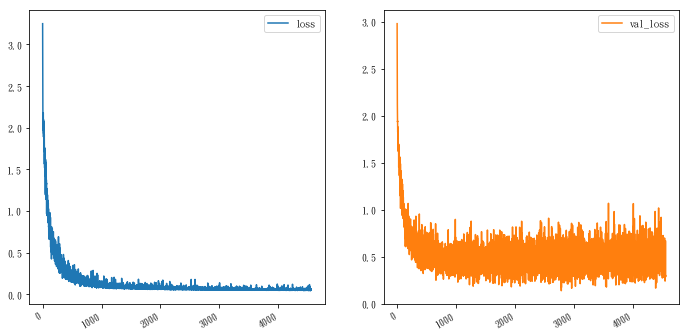

In [23]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216868E7F98>,
      dtype=object)

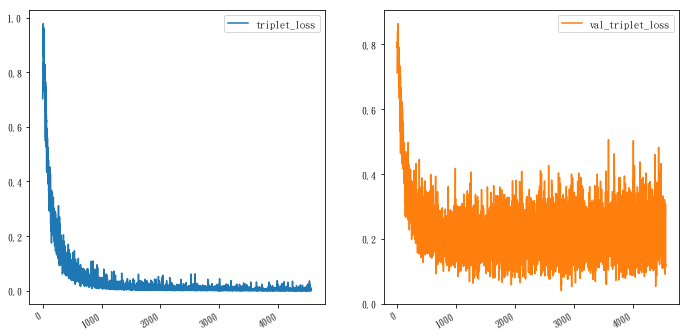

In [24]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021686BBE940>,
      dtype=object)

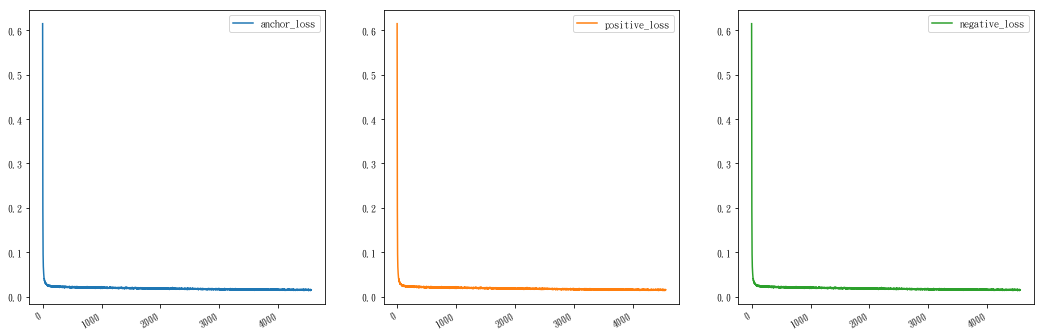

In [25]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021686A00F28>,
      dtype=object)

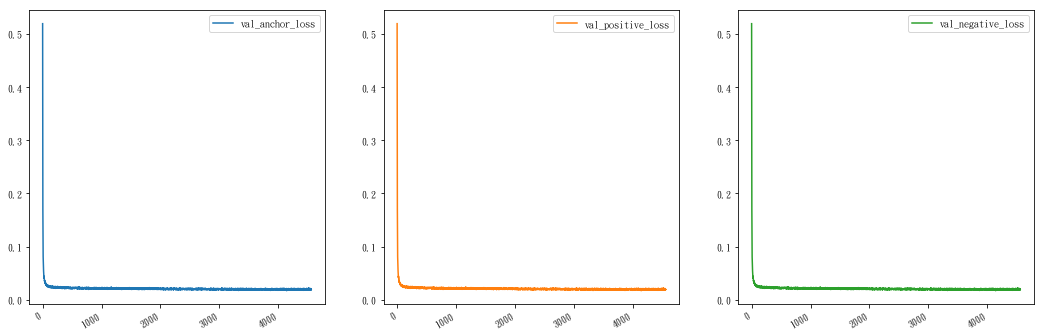

In [26]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))